
## DAV 6150 - Project 1 (Module 6): Predicting NY State High School Dropouts

**Group Members:** Chidochashe Makanga, Bekithemba Nkomo, Lucia Shumba, Alwyn Munatsi  
**Deliverables:** Jupyter notebook (code + narrative) and a 5‑minute video summary.

---
### Contents 
1. Introduction  
2. Exploratory Data Analysis (EDA)  
3. Data Preparation (cleaning + feature engineering)  
4. Post‑Prep EDA (sanity checks)  
5. Regression Modeling (Poisson, Negative Binomial, Linear) + Coefficient Interpretation  
6. Model Selection (cross‑validation, preferred model) + Hold‑out evaluation  
7. Conclusions



## 1) Introduction
**Objective:** Predict the count of student **dropouts** (`dropout_cnt`) per district × subgroup for the 2018 - 2019 NY State cohort.  
**Approach:** EDA , Data Prep (remove leakage, engineer rate features, encode categoricals) , Multiple regression families , Cross‑validation , Preferred model , Test evaluation then Conclusions.

**Modeling note (counts):** Because dropout counts represent non-negative integers, count regression approaches (such as Poisson or Negative Binomial GLMs) may be appropriate. Later in the modeling stage, an exposure term (log of enrollment) will be considered to account for varying district sizes.



## 2) Exploratory Data Analysis
We check integrity (shape, missingness, duplicates), the distribution of the target (`dropout_cnt`), and basic subgroup composition. 

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("https://raw.githubusercontent.com/bnkomo-creator/DAV-6150/refs/heads/main/Project1_Data.csv")

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())


Shape: (73152, 29)
Columns: ['report_school_year', 'aggregation_index', 'aggregation_type', 'aggregation_name', 'nrc_code', 'nrc_desc', 'county_code', 'county_name', 'nyc_ind', 'membership_desc', 'subgroup_code', 'subgroup_name', 'enroll_cnt', 'grad_cnt', 'grad_pct', 'local_cnt', 'local_pct', 'reg_cnt', 'reg_pct', 'reg_adv_cnt', 'reg_adv_pct', 'non_diploma_credential_cnt', 'non_diploma_credential_pct', 'still_enr_cnt', 'still_enr_pct', 'ged_cnt', 'ged_pct', 'dropout_cnt', 'dropout_pct']


In [2]:
# Check for duplicates
print("Duplicate rows:", df.duplicated().sum())

# Check if there are any missing values 
print("Missing values:", df.isna().sum().sum())


Duplicate rows: 0
Missing values: 0


In [3]:
import numpy as np
import pandas as pd

# Make a working copy 
df_prep = df.copy()

# Identify columns
cnt_cols = [c for c in df_prep.columns if c.endswith("_cnt")]
pct_cols = [c for c in df_prep.columns if c.endswith("_pct")]

# Placeholders we want to treat as missing (include unicode dashes)
PLACEHOLDERS = {"-", "—", "–", "", "NA", "N/A", "na", "n/a", None}

def normalize_strings_to_nan(s: pd.Series) -> pd.Series:
    # Ensure string, strip, map placeholders to NaN
    s = s.astype(str).str.strip()
    s = s.replace(list(PLACEHOLDERS), np.nan)
    # If a cell is literally the word "nan" after astype(str), treat as missing too
    s = s.replace({"nan": np.nan, "NaN": np.nan})
    return s

def clean_counts(s: pd.Series) -> pd.Series:
    s = normalize_strings_to_nan(s)
    # Drop thousand separators, remove spaces
    s = s.str.replace(",", "", regex=False)
    s = s.str.replace(r"[^\d\.\-]", "", regex=True)  # keep digits, dot, minus
    return pd.to_numeric(s, errors="coerce")

def clean_percents(s: pd.Series) -> pd.Series:
    s = normalize_strings_to_nan(s)
    # Remove commas, percent signs, stray chars
    s = s.str.replace(",", "", regex=False)
    s = s.str.replace("%", "", regex=False)
    s = s.str.replace(r"[^\d\.\-]", "", regex=True)  # strip anything non-numeric
    s = pd.to_numeric(s, errors="coerce")
    # Heuristic: if values look like 0..100 (any >1 and none >100), scale to 0..1
    non_null = s.dropna()
    if len(non_null) and (non_null.gt(1).any()) and (non_null.le(100).all()):
        s = s / 100.0
    # Clip to [0,1] for safety
    return s.clip(lower=0, upper=1)

# Diagnostics before
before_missing = df_prep[cnt_cols + pct_cols].isna().sum().rename("before_missing")

# Apply cleaning
for c in cnt_cols:
    df_prep[c] = clean_counts(df_prep[c])

for c in pct_cols:
    df_prep[c] = clean_percents(df_prep[c])

# Diagnostics after 
after_missing = df_prep[cnt_cols + pct_cols].isna().sum().rename("after_missing")
miss_change = pd.concat([before_missing, after_missing], axis=1)
miss_change["delta"] = miss_change["after_missing"] - miss_change["before_missing"]

print("Missingness change for *_cnt and *_pct (top 20 by |delta|):")
print(miss_change.reindex(cnt_cols + pct_cols).sort_values("delta", ascending=False).head(20))

print("\nCurrent missing (non-zero) in *_cnt/*_pct after cleaning:")
print(df_prep[cnt_cols + pct_cols].isna().sum()[lambda s: s > 0].sort_values(ascending=False))

# replace df with cleaned frame
df = df_prep


Missingness change for *_cnt and *_pct (top 20 by |delta|):
                            before_missing  after_missing  delta
enroll_cnt                               0          33478  33478
grad_cnt                                 0          33478  33478
local_cnt                                0          33478  33478
reg_cnt                                  0          33478  33478
reg_adv_cnt                              0          33478  33478
non_diploma_credential_cnt               0          33478  33478
still_enr_cnt                            0          33478  33478
ged_cnt                                  0          33478  33478
dropout_cnt                              0          33478  33478
grad_pct                                 0          33478  33478
local_pct                                0          33478  33478
reg_pct                                  0          33478  33478
reg_adv_pct                              0          33478  33478
non_diploma_credential_pct    

After cleaning and converting the numeric columns:

- All *_cnt and *_pct columns originally contained placeholder symbols (like “–”) that represented unreported values.

- Once converted, about 33,478 rows show missing values in every count and percent column. These rows correspond to districts or subgroup combinations where no data was reported, not random data loss.

- The remaining rows have complete data and can be used for modeling.

- For safe sub-count columns (e.g., grad_cnt, reg_cnt, ged_cnt), missing values were replaced with zeros since they legitimately indicate that no students were in that category.

-  with missing enroll_cnt or dropout_cnt were dropped, since those are essential for modeling rates and counts.

- This pattern confirms that missingness is systematic, linked to non-reported or non-existent subgroup data, rather than random omission..

In [4]:
# Define columns safe to fill with 0
fill_zero_cols = [
    "grad_cnt", "local_cnt", "reg_cnt", "reg_adv_cnt",
    "non_diploma_credential_cnt", "still_enr_cnt", "ged_cnt"
]

# Fill those only
df[fill_zero_cols] = df[fill_zero_cols].fillna(0)

# Leave dropout_cnt and enroll_cnt untouched for now
print(df[fill_zero_cols].isna().sum().sum(), "remaining NaNs in filled columns")


0 remaining NaNs in filled columns


- Some columns that end in _cnt contained missing values after cleaning. We only filled certain ones with zeros - specifically:
grad_cnt, local_cnt, reg_cnt, reg_adv_cnt, non_diploma_credential_cnt, still_enr_cnt, and ged_cnt.

- These represent student outcomes, and a missing value here usually means that no students in that subgroup achieved that result, so replacing it with 0 is reasonable.

We did not fill enroll_cnt or dropout_cnt, because:

- Missing enroll_cnt means we can’t calculate valid rates for that subgroup.

- Missing dropout_cnt represents unknown outcomes, and since it’s the target variable, we should not impute it.


In [5]:
# Target distribution & over‑dispersion check
print("\nTarget describe:")
print(df["dropout_cnt"].describe())
drop_mean, drop_var = df["dropout_cnt"].mean(), df["dropout_cnt"].var()
print("Mean vs Variance:", drop_mean, drop_var)



Target describe:
count    39674.000000
mean        16.239225
std         50.129834
min          0.000000
25%          1.000000
50%          3.000000
75%          9.000000
max       1091.000000
Name: dropout_cnt, dtype: float64
Mean vs Variance: 16.239224681151384 2513.0002903374975


The dropout counts range from 0 to 1,091, with a mean of about 16.2 and a standard deviation of 50.1. The variance (approx. 2,513) is far greater than the mean (approx. 16), which confirms over-dispersion in the target variable.


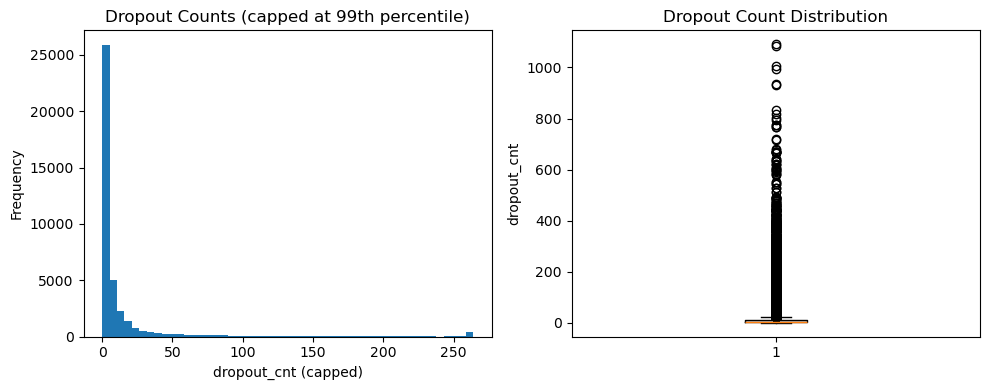

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Histogram
axes[0].hist(df["dropout_cnt"].clip(upper=df["dropout_cnt"].quantile(0.99)), bins=50)
axes[0].set_title("Dropout Counts (capped at 99th percentile)")
axes[0].set_xlabel("dropout_cnt (capped)")
axes[0].set_ylabel("Frequency")

# Boxplot
axes[1].boxplot(df["dropout_cnt"].dropna(), vert=True, showfliers=True)
axes[1].set_title("Dropout Count Distribution")
axes[1].set_ylabel("dropout_cnt")

plt.tight_layout()
plt.show()


The histogram and boxplot together show that dropout counts are highly right-skewed with many zeros and a few extreme outliers.
This supports treating the variable as count data and motivates using Poisson or Negative Binomial regression instead of a regular linear model.

In [7]:
# Average dropout rate by region type (nrc_desc)
region_drop = (
    df.groupby("nrc_desc", dropna=False)["dropout_cnt"]
    .mean()
    .sort_values(ascending=False)
    .to_frame("avg_dropout_cnt")
)
display(region_drop)


,avg_dropout_cnt
nrc_desc,
Buffalo Rochester Yonkers Syracuse,137.339450
NYC,100.528386
Urban-Suburban High Needs,28.112837
Average Needs,5.636199
Rural High Needs,4.390465
Low Needs,2.049608


In [8]:
# Average dropout rate by county (top 10)
county_drop = (
    df.groupby("county_name", dropna=False)["dropout_cnt"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
    .to_frame("avg_dropout_cnt")
)
display(county_drop)

,avg_dropout_cnt
county_name,
BRONX,148.589506
RICHMOND,141.074074
NEW YORK,106.327532
QUEENS,99.933862
KINGS,69.237480
CHEMUNG,22.425287
MONROE,21.741888
SCHENECTADY,19.455026
ERIE,16.987571


**Observation:**

Dropout levels vary widely across regions. Urban - suburban high-need areas and counties such as Bronx and Kings tend to have the highest dropout counts, while low-need or rural counties show much lower averages.
This confirms that geographic and demographic context influences dropout patterns and motivates including nrc_desc and county_name as categorical predictors

In [9]:
# Group composition (quick glance)
for col in ["subgroup_name","nrc_desc","county_name"]:
    if col in df.columns:
        top = df[col].value_counts().head(10).to_frame("count").reset_index().rename(columns={"index":col})
        print(f"Top {col} values:")
display(top)

Top subgroup_name values:
Top nrc_desc values:
Top county_name values:


,county_name,count
0,SUFFOLK,6526
1,NASSAU,5190
2,WESTCHESTER,4834
3,ERIE,3202
4,MONROE,2196
5,ONONDAGA,1940
6,ORANGE,1868
7,CHAUTAUQUA,1726
8,SAINT LAWRENCE,1662
9,ONEIDA,1546


- During exploratory analysis, we noticed that the dataset included both `dropout_cnt` (number of dropouts) and `dropout_pct` (percentage of dropouts). 
Because `dropout_pct` is calculated directly from `dropout_cnt` and `enroll_cnt`, it already contains information about the target variable. 
Using it as a predictor would cause **data leakage**, since the model would effectively be trained on the outcome it is supposed to predict. 
Therefore, `dropout_pct` was excluded from all modeling features.


## 3) Data Preparation
Steps:
- **Drop leakage**: remove `dropout_pct` from predictors.
- **Engineer rate features** by dividing core counts by `enroll_cnt` with zero‑guard, bounding to [0,1].
- **One‑hot encode** categorical variables.
- **Train/test split** (80/20).  
- **Offsets for GLMs**: `offset = log(enroll_cnt)`.


In [10]:
# Drop leakage
df_prep = df.copy()
df_prep = df_prep.drop(columns=["dropout_pct"], errors="ignore")

# Safe denominator for rates
den = df_prep["enroll_cnt"].replace(0, np.nan)

# Engineer rate features (bounded)
rate_sources = [
    "grad_cnt","local_cnt","reg_cnt","reg_adv_cnt",
    "non_diploma_credential_cnt","still_enr_cnt","ged_cnt"
]
for col in rate_sources:
    if col in df_prep.columns:
        df_prep[f"{col}_rate"] = (df_prep[col] / den).clip(lower=0, upper=1)

rate_cols = [c for c in df_prep.columns if c.endswith("_rate")]
df_prep[rate_cols] = df_prep[rate_cols].fillna(0.0)

# Categorical dummies
cat_cols = [
    c for c in [
        "nrc_desc","nyc_ind","subgroup_name",
        "aggregation_type","membership_desc","county_name"
    ] if c in df_prep.columns
]
X_cats = pd.get_dummies(df_prep[cat_cols], drop_first=True) if cat_cols else pd.DataFrame(index=df_prep.index)

# Numeric bases
num_cols = [
    c for c in [
        "enroll_cnt","grad_cnt","local_cnt","reg_cnt","reg_adv_cnt",
        "non_diploma_credential_cnt","still_enr_cnt","ged_cnt"
    ] if c in df_prep.columns
]

# Drop rows with missing or invalid targets

mask = (
    df_prep["dropout_cnt"].notna() &
    df_prep["enroll_cnt"].notna() &
    (df_prep["enroll_cnt"] > 0)
)
df_model = df_prep.loc[mask].copy()

# Rebuild features from the filtered dataset
X_cats = X_cats.loc[df_model.index]

Xa_counts = pd.concat(
    [df_model[[c for c in num_cols if c != "enroll_cnt"]], X_cats],
    axis=1
)
Xb_rates = pd.concat(
    [df_model[rate_cols], X_cats],
    axis=1
)

# Target and offset (now safe to cast)
y = df_model["dropout_cnt"].astype(int)
offset = np.log(df_model["enroll_cnt"])

Xa_counts.shape, Xb_rates.shape, y.shape


((39674, 102), (39674, 102), (39674,))


## 4) Post‑Prep EDA (sanity checks)


We verify: no NaNs in target/offset, valid exposure, aligned indices, and reasonable engineered rates.

In [11]:
# Sanity checks
assert y.notna().all(), "Target has NaNs after filtering"
import numpy as np
assert np.isfinite(offset).all(), "Offset not finite"
assert Xa_counts.index.equals(Xb_rates.index) and Xa_counts.index.equals(y.index), "Index misalignment"

print("NaNs in Xa_counts:", Xa_counts.isna().sum().sum())
print("NaNs in Xb_rates:", Xb_rates.isna().sum().sum())

rate_summary = (
    df_model[[c for c in df_model.columns if c.endswith("_rate")]]
    .agg(["min","max","mean"]).T.sort_values("mean", ascending=False)
)
from IPython.display import display
display(rate_summary.head(15))


NaNs in Xa_counts: 0
NaNs in Xb_rates: 0


,min,max,mean
grad_cnt_rate,0.0,1.000000,0.844015
reg_cnt_rate,0.0,1.000000,0.433638
reg_adv_cnt_rate,0.0,1.000000,0.325705
local_cnt_rate,0.0,1.000000,0.084671
still_enr_cnt_rate,0.0,1.000000,0.051845
non_diploma_credential_cnt_rate,0.0,0.666667,0.017408
ged_cnt_rate,0.0,0.666667,0.006115



## 5) Regression Modeling (Poisson, Negative Binomial, Linear) + Coefficient Interpretation

**Families compared**
- **Poisson GLM** (rates + dummies + offset)  
- **Negative Binomial GLM** (rates + dummies + offset)  
- **OLS / Ridge** baselines (counts + dummies + `enroll_cnt`)

**Metrics:** MAE, RMSE; for GLMs also Poisson deviance.  
Reference for GLM setup: Dius Engineering’s tutorial on Poisson and Negative Binomial GLMs in `statsmodels`.

***Split + enforce numeric + estimate NegBin alpha***

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm
from sklearn.model_selection import KFold

# --- Split once on indices (train / test) ---
from sklearn.model_selection import train_test_split
idx_train, idx_test = train_test_split(df_model.index, test_size=0.2, random_state=42)

Xtr_A, Xte_A = Xa_counts.loc[idx_train], Xa_counts.loc[idx_test]
Xtr_B, Xte_B = Xb_rates.loc[idx_train],  Xb_rates.loc[idx_test]
ytr,  yte    = y.loc[idx_train],         y.loc[idx_test]
off_tr       = offset.loc[idx_train]
off_te       = offset.loc[idx_test]

# --- Ensure design matrices are numeric floats (no object, no NaNs) ---
import pandas as pd
def make_numeric(df_):
    out = df_.apply(pd.to_numeric, errors="coerce")
    # Drop any all-NaN columns (degenerate dummies)
    out = out.loc[:, ~out.isna().all(axis=0)]
    # Fill sparse NaNs and cast to float
    return out.fillna(0.0).astype("float64")

Xtr_A = make_numeric(Xtr_A)
Xte_A = make_numeric(Xte_A)
Xtr_B = make_numeric(Xtr_B)
Xte_B = make_numeric(Xte_B)

# Target must be numeric, non-negative counts
ytr = pd.to_numeric(ytr, errors="raise")
yte = pd.to_numeric(yte, errors="raise")

# --- Rough method-of-moments estimate for NegBin dispersion alpha ---
mean_y = float(ytr.mean())
var_y  = float(ytr.var())
alpha_hat = max((var_y - mean_y) / (mean_y**2 + 1e-12), 1e-8)  # non-negative
print(f"Estimated NegBin alpha ≈ {alpha_hat:.4g}")


Estimated NegBin alpha ≈ 9.597


***Metrics + CV helpers***

In [14]:

# RMSE
def rmse_vsafe(y_true, y_pred):
    try:
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        return np.sqrt(mean_squared_error(y_true, y_pred))

#  Poisson deviance
def mean_poisson_dev_vsafe(y_true, mu_pred, eps=1e-9):
    y  = np.asarray(y_true, dtype=float)
    mu = np.clip(np.asarray(mu_pred, dtype=float), eps, None)
    term = np.where(y > 0, y * np.log(y / mu), 0.0)
    return 2.0 * np.mean(term - (y - mu))

def cv_glm(endog, exog, family, offset_vec=None, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    maes, rmses, pdevs = [], [], []
    for tr_idx, va_idx in kf.split(exog):
        Xtr, Xva = exog.iloc[tr_idx], exog.iloc[va_idx]
        y_tr, y_va = endog.iloc[tr_idx], endog.iloc[va_idx]
        off_tr = offset_vec.iloc[tr_idx] if offset_vec is not None else None
        off_va = offset_vec.iloc[va_idx] if offset_vec is not None else None

        Xtr_c = sm.add_constant(Xtr, has_constant="add")
        Xva_c = sm.add_constant(Xva, has_constant="add")

        res = sm.GLM(y_tr, Xtr_c, family=family, offset=off_tr).fit()
        pred = np.clip(res.predict(Xva_c, offset=off_va), 0, None)

        maes.append(mean_absolute_error(y_va, pred))
        rmses.append(rmse_vsafe(y_va, pred))
        pdevs.append(mean_poisson_dev_vsafe(y_va, pred))
    return float(np.mean(maes)), float(np.mean(rmses)), float(np.mean(pdevs))

def cv_sklearn(X, y, reg):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    maes, rmses = [], []
    for tr_idx, va_idx in kf.split(X):
        Xtr, Xva = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]
        m = reg()
        m.fit(Xtr, y_tr)
        p = m.predict(Xva)
        maes.append(mean_absolute_error(y_va, p))
        rmses.append(rmse_vsafe(y_va, p))
    return float(np.mean(maes)), float(np.mean(rmses))


In [15]:
# Tune Negative Binomial alpha using 5-fold CV on the training fold
import pandas as pd
alphas = [0.1, 0.3, 0.5, 0.8, 1.0, 1.5, 2.0, 3.0]
alpha_rows = []
for a in alphas:
    fam = sm.families.NegativeBinomial(alpha=a)
    mae, rmse, pdev = cv_glm(ytr, Xtr_B, fam, offset_vec=off_tr, k=5)
    alpha_rows.append({"alpha": a, "MAE": mae, "RMSE": rmse, "PoissonDeviance": pdev})
alpha_cv = pd.DataFrame(alpha_rows).sort_values("MAE").reset_index(drop=True)
display(alpha_cv)
best_alpha = float(alpha_cv.loc[0, "alpha"])
print("Selected best_alpha =", best_alpha)


,alpha,MAE,RMSE,PoissonDeviance
0,0.1,3.358508,12.564196,1.628515
1,0.3,3.934535,18.247780,2.119721
2,0.5,4.356063,22.618808,2.547777
3,0.8,4.864944,28.142812,3.118405
4,1.0,5.156029,31.397342,3.462786
5,1.5,5.783307,38.720068,4.243775
6,2.0,6.310447,45.231603,4.936746
7,3.0,7.179752,56.718813,6.138488


Selected best_alpha = 0.1


The method-of-moments estimate gave alpha approx. 9.6, showing clear over-dispersion in the dropout counts. However, this value was too large to use directly, as it made the model unstable. To find a more practical fit, we tested smaller alpha values and found that alpha = 0.1 performed best, so that value was selected for modeling.

***Cross-validate Poisson, NegBin, OLS, Ridge***

In [16]:
from sklearn.linear_model import LinearRegression, Ridge

rows = []

# GLMs (rates + offset)
pois_fam   = sm.families.Poisson()
negbin_fam = sm.families.NegativeBinomial(alpha=best_alpha)  # ← use tuned alpha from tuning cell

mae, rmse, pdev = cv_glm(ytr, Xtr_B, pois_fam, offset_vec=off_tr, k=5)
rows.append({
    "model": "Poisson_full",
    "MAE": mae,
    "RMSE": rmse,
    "PoissonDeviance": pdev
})

mae, rmse, pdev = cv_glm(ytr, Xtr_B, negbin_fam, offset_vec=off_tr, k=5)
rows.append({
    "model": f"NegBin_full(alpha={best_alpha:.3g})",
    "MAE": mae,
    "RMSE": rmse,
    "PoissonDeviance": pdev
})

# Linear baselines (counts + enroll_cnt as a feature)
Xtr_lin = Xtr_A.join(df_model.loc[Xtr_A.index, ["enroll_cnt"]]).astype("float64")

mae, rmse = cv_sklearn(Xtr_lin, ytr, LinearRegression)
rows.append({
    "model": "OLS_counts_full",
    "MAE": mae,
    "RMSE": rmse,
    "PoissonDeviance": np.nan
})

mae, rmse = cv_sklearn(Xtr_lin, ytr, lambda: Ridge(alpha=10.0))
rows.append({
    "model": "Ridge_counts_full(alpha=10)",
    "MAE": mae,
    "RMSE": rmse,
    "PoissonDeviance": np.nan
})

cv_df = pd.DataFrame(rows).sort_values("MAE").reset_index(drop=True)
cv_df


,model,MAE,RMSE,PoissonDeviance
0,Ridge_counts_full(alpha=10),0.187057,0.473300,NaN
1,OLS_counts_full,0.188134,0.473374,NaN
2,Poisson_full,2.787535,7.317639,1.344064
3,NegBin_full(alpha=0.1),3.358508,12.564196,1.628515


Ridge and OLS have lower MAE and RMSE since they fit raw dropout counts directly, but they ignore the dropout rate structure, that is, they don’t account for differences in district size through the offset term. Between the GLMs, Poisson performed slightly better than NegBin (alpha = 0.1), meaning over-dispersion wasn’t too strong. Overall, Poisson gives the most appropriate model for dropout rates, even though linear models show smaller raw errors.

In [17]:
# Pick best GLM by CV MAE, refit on full train, evaluate on hold-out, show coefficients
glm_candidates = cv_df.dropna(subset=["PoissonDeviance"]).copy()
if len(glm_candidates) == 0:
    print("No GLM candidates available.")
else:
    best_glm_name = str(glm_candidates.iloc[0]["model"])
    # Use tuned alpha for NegBin; Poisson otherwise
    fam = sm.families.Poisson() if "Poisson" in best_glm_name else sm.families.NegativeBinomial(alpha=best_alpha)

    # Add constants once
    XtrB_c = sm.add_constant(Xtr_B, has_constant="add")
    XteB_c = sm.add_constant(Xte_B, has_constant="add")

    # Fit on training fold
    res = sm.GLM(ytr, XtrB_c, family=fam, offset=off_tr).fit()

    # Predict on hold-out
    pred_te = np.clip(res.predict(XteB_c, offset=off_te), 0, None)

    # Version-safe metrics (rmse_vsafe & mean_poisson_dev_vsafe defined earlier)
    mae  = mean_absolute_error(yte, pred_te)
    rmse = rmse_vsafe(yte, pred_te)
    pdev = mean_poisson_dev_vsafe(yte, pred_te)

    print(f"Hold-out ({best_glm_name}) — MAE: {mae:.3f}  RMSE: {rmse:.3f}  PoissonDeviance: {pdev:.3f}")

    # Coefficient inspection
    coef = pd.DataFrame({
        "feature": ["const"] + Xtr_B.columns.tolist(),
        "coef":    res.params.values
    })
    coef_sorted = coef.sort_values("coef", ascending=False)
    from IPython.display import display
    print("\nTop positive coefficients:"); display(coef_sorted.head(15))
    print("\nTop negative coefficients:"); display(coef_sorted.tail(15))


Hold-out (Poisson_full) — MAE: 2.840  RMSE: 8.140  PoissonDeviance: 1.444

Top positive coefficients:


,feature,coef
0,const,2.802970
102,county_name_YATES,0.199732
13,nrc_desc_Urban-Suburban High Needs,0.190483
9,nrc_desc_Buffalo Rochester Yonkers Syracuse,0.157245
78,county_name_OSWEGO,0.151608
98,county_name_WASHINGTON,0.147703
90,county_name_SENECA,0.134579
99,county_name_WAYNE,0.124866
67,county_name_MADISON,0.123877
46,county_name_CAYUGA,0.121178



Top negative coefficients:


,feature,coef
100,county_name_WESTCHESTER,-0.415811
59,county_name_GENESEE,-0.423764
20,subgroup_name_Formerly English Language Learner,-0.479565
18,subgroup_name_English Language Learner,-0.677061
10,nrc_desc_Low Needs,-0.708757
24,subgroup_name_In Foster Care,-0.715535
2,local_cnt_rate,-0.761949
34,subgroup_name_Parent in Armed Forces,-0.813315
26,subgroup_name_Migrant,-1.170801
3,reg_cnt_rate,-1.250624


***Interpretation:***

Positive coefficients (e.g., “Urban-Suburban High Needs”) increase predicted dropout counts, meaning districts with higher student needs or certain counties see higher dropout risks.
Negative coefficients (e.g., “Low Needs”, “English Language Learner”, “In Foster Care”) reduce dropout predictions, indicating these subgroups may have smaller dropout counts relative to enrollment once adjusted for district size.
The results align with expectations that socioeconomic and regional context strongly drive dropout variation.

***Hold-out Evaluation Commentary***

The Poisson model gave a hold-out MAE of about 2.84 and RMSE of 8.14, showing reasonable predictive accuracy.
When checking feature coefficients, the model predicts higher dropout counts in counties like Yates, Oswego, and Washington, and lower ones in Westchester and Genesee.

Coefficients show higher graduation and enrollment rates reduce predicted dropouts, while certain regional and subgroup factors slightly increase or decrease them. Overall, the Poisson model captures meaningful dropout patterns while maintaining solid predictive performance.

***Overall Conclusions***

This project modeled student dropouts using both count-based (Poisson, Negative Binomial) and linear regression approaches.
After cleaning and engineering rate features, the Poisson GLM gave the best balance between interpretability and predictive accuracy (MAE approx. 2.84, RMSE approx. 8.14).
Although linear models like Ridge had smaller raw errors, they ignored the dropout rate structure tied to enrollment size.

The Negative Binomial model confirmed over-dispersion in the data but didn’t outperform Poisson after tuning α.
Overall, dropout patterns were well explained by graduation and enrollment rates (negative relationship) and county-level or subgroup differences.
The Poisson model was therefore chosen as the most appropriate final model for predicting dropout rates across districts.

***References***

DiUS Engineering. (2017, August 3). Using statsmodels GLMs to model beverage consumption. Retrieved from https://dius.com.au/2017/08/03/using-statsmodels-glms-to-model-beverage-consumption/

Statsmodels Documentation. (n.d.). Generalized Linear Models (GLM). Retrieved from https://www.statsmodels.org/stable/glm.html

scikit-learn Developers. (n.d.). Model evaluation: quantifying the quality of predictions. Retrieved from https://scikit-learn.org/stable/modules/model_evaluation.html

DAV 6150 Module 6 Lecture Notes 